In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import gym

from rrc.env import cube_env, initializers, reward_fns, wrappers, make_env
from rrc_iprl_package.envs import rrc_utils
from rrc_iprl_package.control import controller_utils_cube as c_utils
from rrc_iprl_package.control.control_policy import ImpedanceControllerPolicy
from trifinger_simulation.tasks.move_cube import Pose

/scr1/.pyenv/versions/miniconda3-latest/envs/rrc/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Residual Impedance Control

In [2]:
import os
import wandb
import pandas as pd
import numpy as np
import os.path as osp
from trifinger_simulation.tasks.move_cube import Pose
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import CombinedExtractor
from stable_baselines3.common.preprocessing import get_flattened_obs_dim, is_image_space
from stable_baselines3 import HerReplayBuffer, SAC, TD3, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch.nn as nn
import json


class HERCombinedExtractor(CombinedExtractor):
    """
    HERCombinedExtractor is a combined extractor which only extracts pre-specified observation_keys to include in
    the observation, while retaining them at the environment level so that they may still be stored in the replay buffer
    """

    def __init__(self, observation_space: gym.spaces.Dict, cnn_output_dim: int = 256, observation_keys: list = []):
        # TODO we do not know features-dim here before going over all the items, so put something there. This is dirty!
        super(CombinedExtractor, self).__init__(observation_space, features_dim=1)

        extractors = {}

        total_concat_size = 0
        for key in observation_keys:
            subspace = observation_space.spaces[key]
            # The observation key is a vector, flatten it if needed
            extractors[key] = nn.Flatten()
            total_concat_size += get_flattened_obs_dim(subspace)

        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size
        

def make_vec_env(run):
    if run.config.get('contact'):
        env_cls = cube_env.ContactForceCubeEnv
    else:
        env_cls = run.config.get('env_cls')

    env_fn = make_env.env_fn_generator(diff=run.config['diff'], visualization=True, save_freq=1, initializer=run.config['init'],
                                       reward_fn=run.config['rew_fn'], residual=run.config.get('residual', False), env_cls=env_cls)
    env = DummyVecEnv([env_fn])
    return env

def make_model(ep_len, lr, exp_dir=None, env=None, use_goal=True,
               use_sde=False, log_std_init=-3, load_path=None,
               residual=False):
    if use_goal:
        obs_keys = ['desired_goal', 'achieved_goal', 'observation']
    else:
        obs_keys = ['observation']

    policy_kwargs = dict(
                    log_std_init=log_std_init,
                    features_extractor_class=HERCombinedExtractor,
                    features_extractor_kwargs=dict(observation_keys=obs_keys))
    if use_sde:
        sde_kwargs = dict(
                use_sde=True,
                use_sde_at_warmup=False,
                sde_sample_freq=64)
    else:
        sde_kwargs = {}

    rb_kwargs = dict(n_sampled_goal=4,
                     goal_selection_strategy='future',
                     online_sampling=False,
                     max_episode_length=ep_len)

    model = SAC('MultiInputPolicy', env,
                # tensorboard_log=exp_dir,
                replay_buffer_class=HerReplayBuffer,
                # Parameters for HER
                replay_buffer_kwargs=rb_kwargs,
                policy_kwargs=policy_kwargs,
                verbose=1, buffer_size=int(1e6),
                learning_starts=20000,
                learning_rate=lr,
                gamma=0.99, batch_size=256, residual=residual, **sde_kwargs)
    if load_path is not None:
        if osp.isdir(load_path):
            load_path = osp.join(load_path, 'best_model.zip')
        model.load(load_path, env)
    return model

In [3]:
api = wandb.Api()
run_id = '9sp6xgul'
run = api.run('krshna/cvxrl/{}'.format(run_id))

# Create DummyVecEnv
env = make_vec_env(run)

# Create model
use_goal = not(run.config.get('no_goal'))
use_sde = not(run.config.get('no_sde'))
load_path = None # osp.join(get_save_path(run), '2e+05-steps.zip')
model = make_model(run.config.get('ep_len'), run.config['lr'], use_goal=use_goal, use_sde=use_sde, env=env,
                   load_path=load_path)

Using cuda device


In [5]:
env_fn = rrc_utils.build_env_fn(residual=True, goal_relative=True, goal_env=True, flatten=False)
env = env_fn()
obs = env.reset()
# model.predict()

/scr1/.pyenv/versions/miniconda3-latest/envs/rrc/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/scr-ssd/ksrini/trifinger_simulation/python/trifinger_simulation/trifinger_platform.py:301: UserWarning: Cameras are not enabled, so images in the camera observation are not initialized.  Create `TriFingerPlatform` with `enable_cameras=True` to get rendered camera images.
  "Cameras are not enabled, so images in the camera observation"



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In [6]:
obs

{'robot_position': array([ 0.26655893,  0.75593713, -1.20290453,  0.42945231,  0.38568846,
        -1.16772889,  0.13347648,  0.5122267 , -1.20629846]),
 'robot_velocity': array([ 0.00070305,  0.00272229, -0.00520968, -0.00190879, -0.00380348,
         0.00825653, -0.00222574, -0.00320084,  0.00815314]),
 'robot_tip_positions': array([[ 0.01229308,  0.08997428,  0.013966  ],
        [ 0.01305903,  0.03041354,  0.01511717],
        [-0.04588382,  0.02965632,  0.01665059]]),
 'object_position': array([-0.01673793,  0.05868907,  0.03461131]),
 'object_orientation': array([ 0.01717042, -0.00700465, -0.36796655,  0.92965409]),
 'goal_object_position': array([0.    , 0.    , 0.0325]),
 'goal_object_orientation': array([0, 0, 0, 1]),
 'robot_torque': array([ 0.0963928 , -0.10065354, -0.17995342,  0.04433803, -0.03157673,
        -0.05317606, -0.14141271, -0.22600639, -0.13714873]),
 'desired_torque': array([ 0.09644904, -0.10043576, -0.18016181,  0.04418533, -0.03188101,
        -0.0528458 , 

## Residual PD Control

In [16]:
class ResidualPDWrapper(gym.Wrapper):
    def __init__(self, env, Kp=np.eye(3)*np.array([100,100,1]), Kd=1, include_ac=False):
        assert env.relative_goal, 'ResidualPDWrapper requires env.relative_goal=True'
        assert not env.clip_action, 'ResidualPDWrapper requires env.clip_action=False'
        super(ResidualPDWrapper, self).__init__(env)
        self.Kp = Kp
        self.Kd = Kd
        self._obs = self._prev_obs = None
        self.include_ac = include_ac
        if self.include_ac:
            obs_dict = self.env.observation_space.spaces
            obs_dict = {k: obs_dict['observation'][k] for k in obs_dict['observation']}
            obs_dict['pd_action'] = gym.spaces.Box(low=-np.ones(3), high=np.ones(3))
            self.observation_space.spaces['observation'] = obs_dict
    
    def reset(self):
        obs = super(ResidualPDWrapper, self).reset()
        self._prev_obs = None
        self._obs = obs
        if self.include_ac:
            obs['observation']['pd_action'] = self.pd_action(self._obs, self._prev_obs)
        return obs
    
    def step(self, action):
        pd_action = self.pd_action(self._obs, self._prev_obs)
        ac = action + pd_action
        self._prev_obs = self._obs
        obs, r, d, i = self.env.step(ac)
        self._obs = obs
        if self.include_ac:
            obs['observation']['pd_action'] = self.pd_action(self._obs, self._prev_obs)
        return obs, r, d, i
    
    def pd_action(self, observation, prev_observation):
        if observation is None:
            return np.zeros(6)
        if observation['observation'].get('pd_action') is not None:
            return observation['observation']['pd_action']
        err = observation['observation']['position']
        u = -self.Kp @ err
        if prev_observation is None:
            return np.concatenate([u, np.zeros(3)], axis=-1)
        err_diff = observation['observation']['position'] - prev_observation['observation']['position']
        u -= self.Kd * err_diff / self.env.time_step_s
        return np.concatenate([u, np.zeros(3)], axis=-1)

In [21]:
obs[0]['achieved_goal'], obs[0]['desired_goal']

({'position': array([0.11082089, 0.00033355, 0.03254781]),
  'orientation': array([ 7.16961035e-04,  7.69760742e-05, -1.64135309e-01,  9.86437570e-01])},
 {'position': array([0.    , 0.    , 0.0325]),
  'orientation': array([0, 0, 0, 1])})

In [35]:
start = {'position': np.array([0.08533178, 0.01042374, 0.0325452 ]),
         'orientation': np.array([-7.23055100e-04, -1.77149433e-04,  3.76762749e-01,  9.26309493e-01])}
goal = {'position': np.array([0.    , 0.    , 0.0325]),
        'orientation': np.array([0, 0, 0, 1])}

fixed_initializer = FixedInitializer(start, goal)

In [22]:
start2 = {'position': np.array([0.11082089, 0.00033355, 0.03254781]),
  'orientation': np.array([ 7.16961035e-04,  7.69760742e-05, -1.64135309e-01,  9.86437570e-01])}
fixed_initializer = FixedInitializer(start2, goal)

In [36]:
env = wrappers.PyBulletClearGUIWrapper(cube_env.CubeEnv(None, goal_difficulty=1, relative_goal=True, episode_length=500,
                                                        initializer=fixed_initializer, reward_fn=reward_fns.training_reward2, visualization=True))

env = ResidualPDWrapper(env, include_ac=True)

/scr1/.pyenv/versions/miniconda3-latest/envs/rrc/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [24]:
import pybullet as p

In [13]:
import time

In [40]:
o = env.reset()
obs = [o]
d = False
rew = []
time.sleep(3)
while not d:
    o, r, d, i = env.step(np.zeros(6))
    rew.append(r)
    obs.append(o)

In [8]:
env.pd_action(env._obs, env._prev_obs)

array([-1.49021473e+01, -1.92621076e+00, -9.55098842e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

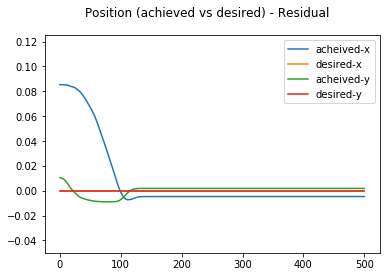

In [41]:
plt.suptitle('Position (achieved vs desired) - Residual')
plt.plot([o['achieved_goal']['position'][0] for o in obs], label='acheived-x')
plt.plot([o['desired_goal']['position'][0] for o in obs], label='desired-x')
plt.plot([o['achieved_goal']['position'][1] for o in obs], label='acheived-y')
plt.plot([o['desired_goal']['position'][1] for o in obs], label='desired-y')
plt.ylim([-0.05, 0.125])
# plt.plot([o['achieved_goal']['position'][2] for o in obs], label='acheived-z')
# plt.plot([o['desired_goal']['position'][2] for o in obs], label='desired-z')
plt.legend()
plt.show()

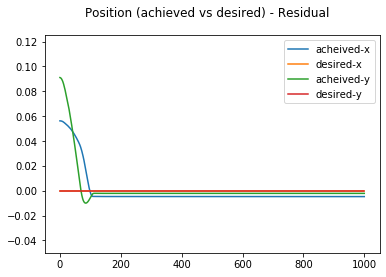

In [8]:
plt.suptitle('Position (achieved vs desired) - Residual')
plt.plot([o['achieved_goal']['position'][0] for o in obs], label='acheived-x')
plt.plot([o['desired_goal']['position'][0] for o in obs], label='desired-x')
plt.plot([o['achieved_goal']['position'][1] for o in obs], label='acheived-y')
plt.plot([o['desired_goal']['position'][1] for o in obs], label='desired-y')
plt.ylim([-0.05, 0.125])
# plt.plot([o['achieved_goal']['position'][2] for o in obs], label='acheived-z')
# plt.plot([o['desired_goal']['position'][2] for o in obs], label='desired-z')
plt.legend()
plt.show()

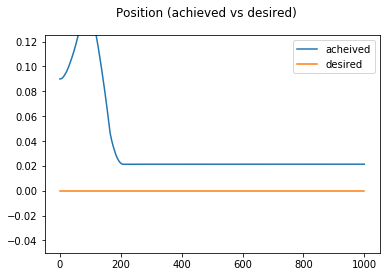

In [51]:
plt.suptitle('Position (achieved vs desired)')
plt.plot([o['achieved_goal']['position'][0] for o in obs], label='acheived')
plt.plot([o['desired_goal']['position'][0] for o in obs], label='desired')
plt.ylim([-0.05, 0.125])
# plt.plot([o['achieved_goal']['position'][1] for o in obs], label='acheived-y')
# plt.plot([o['desired_goal']['position'][1] for o in obs], label='desired-y')
# plt.plot([o['achieved_goal']['position'][2] for o in obs], label='acheived-z')
# plt.plot([o['desired_goal']['position'][2] for o in obs], label='desired-z')

plt.legend()
plt.show()

(-0.05, 0.125)

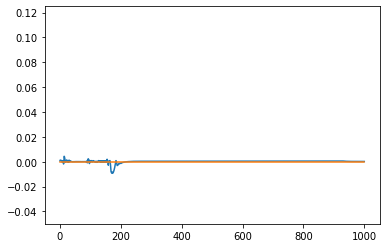

In [52]:
plt.plot([o['achieved_goal']['orientation'][0] for o in obs], label='acheived')
plt.plot([o['desired_goal']['orientation'][0] for o in obs], label='desired')
plt.ylim([-0.05, 0.125])

In [39]:
start = initializers.centered_init(3).get_initial_state()
goal = initializers.centered_init(3).get_goal()

fixed_initializer = FixedInitializer(start, goal)
env = cube_env.CubeEnv(None, goal_difficulty=1, relative_goal=True, episode_length=1000,
                       reward_fn=reward_fns.training_reward2, initializer=fixed_initializer)

/scr1/.pyenv/versions/miniconda3-latest/envs/rrc/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
o = env.reset()
obs = [o]
d = False
rew = []
while not d:
    u = -Kp @ o['observation']['position'] #- Kd * (o['observation']['position'] - obs[-1]['observation']['position']) / env.time_step_s
    u = np.concatenate([u, np.zeros(3)], axis=-1)
    o, r, d, i = env.step(u)
    rew.append(r)
    obs.append(o)